In [ ]:
!pip install segmentation-models-pytorch -q
!pip install -U git+https://github.com/albumentations-team/albumentations -q
!pip install --upgrade opencv-contrib-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset


Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 26.27 MiB/s, done.
Updating files: 100% (12939/12939), done.


In [ ]:
import sys
sys.path.append("/content/Person-Re-Id-Dataset")

In [ ]:
!pip install timm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

"""
Timm: PyTorch Image Models (timm) is a library for state-of-the-art-image classification, containing a collection of image models, optimizers, schedulers, augmentations and much more.
"""
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

"""
tqdm is a library that is used for creating Python Progress Bars. It gets its name from the Arabic name taqaddum, which means 'progress. '
"""
from tqdm import tqdm

In [ ]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = '/archive.zip'

# Directory where you want to extract the files
extract_to_dir = '/content/'

# Create the directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/archive.zip'

In [ ]:
DATA_DIR = "/content/Market-1501-v15.09.15/bounding_box_train"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

df = pd.read_csv(CSV_FILE)
df.head()


,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[11]



A_img = io.imread(DATA_DIR +"/"+ row.Anchor)
P_img = io.imread(DATA_DIR +"/"+ row.Positive)
N_img = io.imread(DATA_DIR +"/"+ row.Negative)

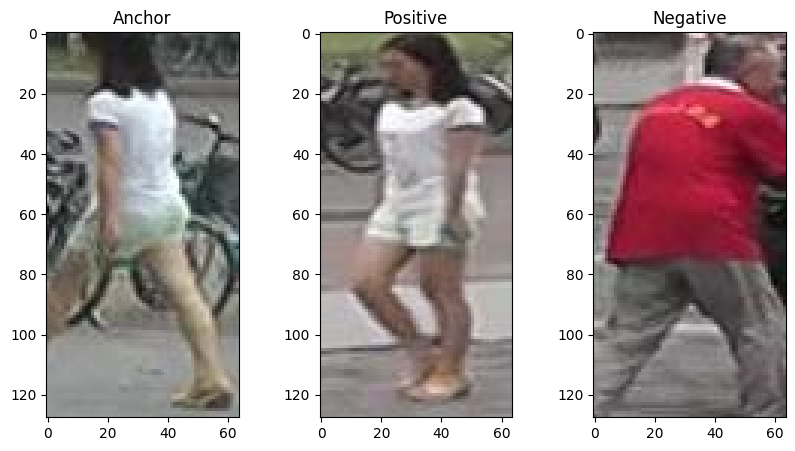

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)


In [ ]:
class APN_Dataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR +"/"+ row.Anchor)
        P_img = io.imread(DATA_DIR +"/"+ row.Positive)
        N_img = io.imread(DATA_DIR +"/"+ row.Negative)

        A_img = torch.from_numpy(A_img).permute(2, 0 ,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0 ,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0 ,1) / 255.0

        return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


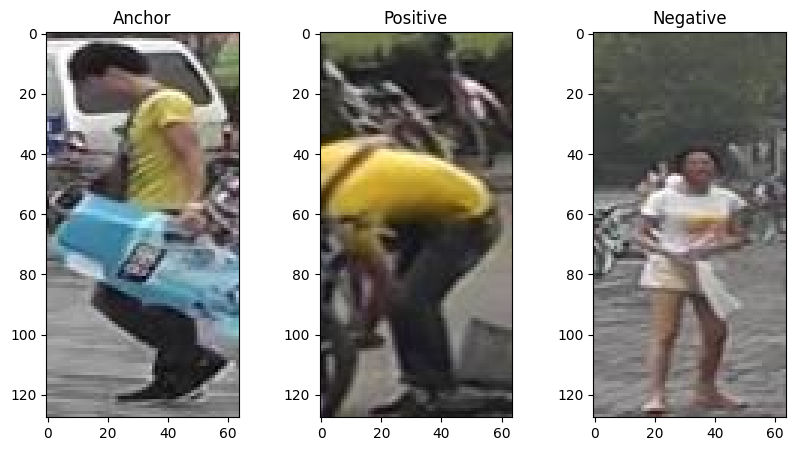

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")
for A, P, N in trainloader:
    break;

print(f"One image batch shape : {A.shape}")

No. of batches in trainloader : 100
No. of batches in validloader : 25
One image batch shape : torch.Size([32, 3, 128, 64])


In [ ]:
class APN_Model(nn.Module):

    def __init__(self, emb_size = 512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features,
                                                out_features = emb_size)


    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train() # ON Dropout
    total_loss = 0.0

    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)
    def eval_fn(model, dataloader, criterion):
      model.eval()  # OFF Dropout
      total_loss = 0.0

      with torch.no_grad():
          for A,P,N in tqdm(dataloader):
              A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

              A_embs = model(A)
              P_embs = model(P)
              N_embs = model(N)

              loss = criterion(A_embs, P_embs, N_embs)

              total_loss += loss.item()

          return total_loss / len(dataloader)
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHT_SUCCESS")

    print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


SAVED_WEIGHT_SUCCESS
EPOCHS: 1 train_loss: 0.6326557376980781 valid_loss: 0.5315836954116822


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


SAVED_WEIGHT_SUCCESS
EPOCHS: 2 train_loss: 0.2846799050271511 valid_loss: 0.4312336504459381


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


SAVED_WEIGHT_SUCCESS
EPOCHS: 3 train_loss: 0.2236556175351143 valid_loss: 0.41161943316459654


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


SAVED_WEIGHT_SUCCESS
EPOCHS: 4 train_loss: 0.15377227425575257 valid_loss: 0.2588239759206772


100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


SAVED_WEIGHT_SUCCESS
EPOCHS: 5 train_loss: 0.09889171525835991 valid_loss: 0.23379450738430024


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


SAVED_WEIGHT_SUCCESS
EPOCHS: 6 train_loss: 0.06584339953958988 valid_loss: 0.14549749374389648


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


EPOCHS: 7 train_loss: 0.051156778931617734 valid_loss: 0.1680211067199707


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


EPOCHS: 8 train_loss: 0.06667512960731983 valid_loss: 0.15051195561885833


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


EPOCHS: 9 train_loss: 0.052415814474225046 valid_loss: 0.20279371708631516


100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


EPOCHS: 10 train_loss: 0.04226618230342865 valid_loss: 0.24615920305252076


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


EPOCHS: 11 train_loss: 0.052148677110672 valid_loss: 0.1766383957862854


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


EPOCHS: 12 train_loss: 0.0428313510119915 valid_loss: 0.1815072053670883


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


EPOCHS: 13 train_loss: 0.04865065835416317 valid_loss: 0.22098897993564606


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


EPOCHS: 14 train_loss: 0.056064169704914096 valid_loss: 0.16647410690784453


100%|██████████| 25/25 [00:26<00:00,  1.06s/it]

EPOCHS: 15 train_loss: 0.038731389939785005 valid_loss: 0.1835377061367035


In [ ]:
# Check if GPU is available, otherwise use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR +"/"+ i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A. to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # c,h,w --> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)

    return df_enc
model.load_state_dict(torch.load("/best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])
df_enc.to_csv("database.csv", index=False)
df_enc.head()

100%|██████████| 4000/4000 [00:45<00:00, 88.45it/s]


,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.678039,0.723380,-0.119814,-0.312414,0.178767,0.231760,-0.157934,0.123368,-0.083437,...,-0.514161,-0.283122,-0.597004,-0.303716,-0.518177,0.052642,0.681177,-0.478736,1.145670,-0.681820
1,1420_c3s3_061978_03.jpg,-0.707896,0.640298,-0.401474,-0.368636,-0.070463,-0.042793,-0.409098,0.381356,-0.105722,...,-0.614588,0.042368,-0.605512,-0.693873,-0.666572,0.565741,0.837280,-0.443149,1.160340,-0.430835
2,1420_c5s3_062565_05.jpg,-0.636253,0.104914,0.281737,-0.444616,-0.126442,0.277709,-0.731153,0.446999,0.077394,...,-0.671305,0.227212,-0.490539,-0.235473,-0.467261,0.086803,0.641857,-0.604054,1.032118,-0.636513
3,1420_c6s3_085592_04.jpg,-0.070136,0.124932,0.626656,-0.457993,0.080909,0.291353,-0.166002,0.137815,0.209585,...,0.003385,-0.148742,-0.504285,0.267116,-0.440129,-0.054103,0.210583,-0.025443,0.484241,-0.283931
4,0663_c5s3_085987_03.jpg,0.130075,-0.829549,1.327438,-0.060614,-0.242242,0.427011,-0.158854,0.235781,1.107679,...,0.097347,-0.490050,-0.621143,0.605365,0.502160,-0.650758,-0.143620,-0.221487,0.325444,0.358915


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR +"/"+ img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

first:--------- 0       1420_c5s3_052165_01.jpg
1       1420_c3s3_061978_03.jpg
2       1420_c5s3_062565_05.jpg
3       1420_c6s3_085592_04.jpg
4       0663_c5s3_085987_03.jpg
                 ...           
3995    0326_c2s3_074602_01.jpg
3996    0566_c3s2_004562_03.jpg
3997    0566_c3s2_013637_01.jpg
3998    0566_c6s2_007768_03.jpg
3999    0566_c6s2_007718_02.jpg
Name: Anchor, Length: 4000, dtype: object
2:--------- /content/Market-1501-v15.09.15/bounding_box_train
3:--------- tensor([[[0.8196, 0.7294, 0.4784,  ..., 0.3333, 0.2863, 0.2706],
         [0.7922, 0.7176, 0.4902,  ..., 0.2549, 0.2353, 0.2353],
         [0.7922, 0.7412, 0.5373,  ..., 0.1922, 0.2000, 0.2118],
         ...,
         [0.5961, 0.5961, 0.5922,  ..., 0.6078, 0.5922, 0.5686],
         [0.5882, 0.5961, 0.5961,  ..., 0.6392, 0.6118, 0.5843],
         [0.5686, 0.5765, 0.5843,  ..., 0.6000, 0.6275, 0.6588]],

        [[0.8196, 0.7294, 0.4784,  ..., 0.3373, 0.2902, 0.2745],
         [0.7922, 0.7176, 0.4902,  ..., 0.258

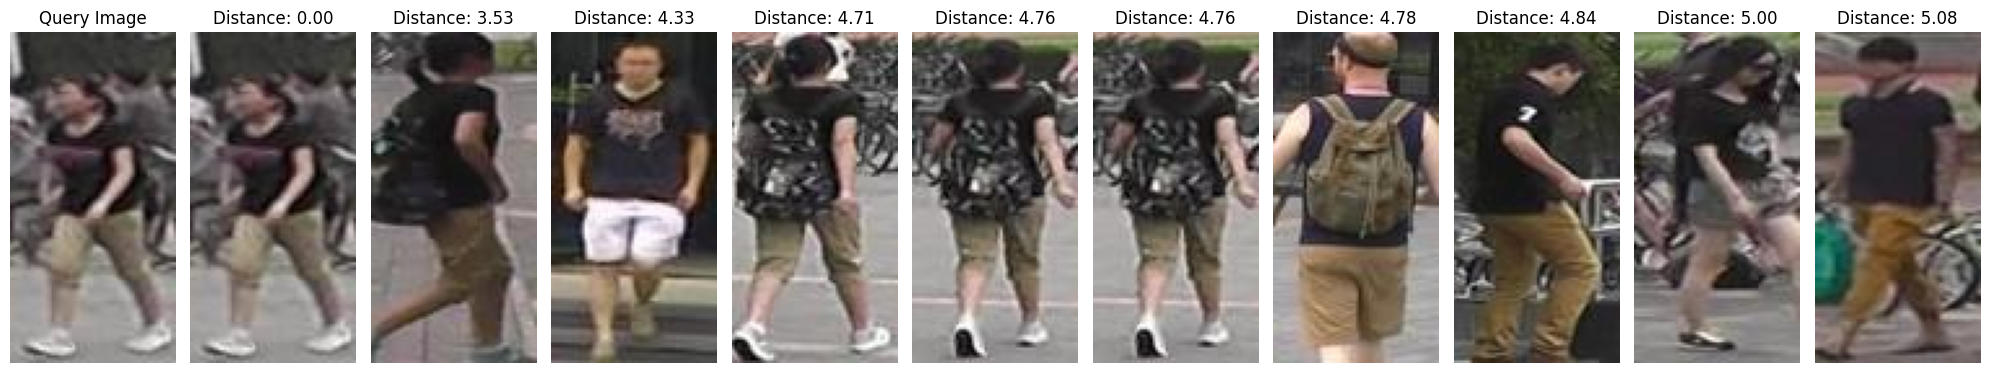

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]
distance = []
print("first:---------",anc_img_names)
print("2:---------",DATA_DIR)
print("3:---------",img)
print("4:---------",img_path)

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)
closest_idx = np.argsort(distance)
from utils import plot_closest_imgs
import os
import matplotlib.pyplot as plt
from skimage import io

def plot_closest_imgs(img_names, data_dir, query_img, query_img_path, closest_idx, distances, no_of_closest=10):
    fig, axes = plt.subplots(1, no_of_closest + 1, figsize=(20, 5))  # +1 for query image

    # Query Image
    query_img = io.imread(query_img_path)
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image')
    axes[0].axis('off')

    # Closest Images
    for i in range(min(no_of_closest, len(closest_idx))):  # Ensure not to exceed available images
        img_name = img_names.iloc[closest_idx[i]]
        img_path = os.path.join(data_dir, img_name)  # Correct path joining
        try:
            img = io.imread(img_path)
            axes[i + 1].imshow(img)
            axes[i + 1].set_title(f'Distance: {distances[closest_idx[i]]:.2f}')
            axes[i + 1].axis('off')
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            axes[i + 1].set_title('Not Found')
            axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest=10)


In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR +"/"+ i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A. to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # c,h,w --> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        # Convert anc_img_names to a DataFrame for concatenation
        anc_img_names_df = pd.DataFrame(anc_img_names, columns=['Anchor'])
        df_enc = pd.concat([anc_img_names_df, encodings], axis=1)

    return df_enc
DATA_DIR="/content/Market-1501-v15.09.15/query"
query_img_names = [file for file in os.listdir('/content/Market-1501-v15.09.15/query') if file.endswith('.jpg')]
query_df = get_encoding_csv(model, query_img_names)
query_df.to_csv("query_database.csv", index=False)
DATA_DIR="/content/Market-1501-v15.09.15/bounding_box_test"
gallery_img_names = [file for file in os.listdir('/content/Market-1501-v15.09.15/bounding_box_test') if file.endswith('.jpg')]
gallery_df = get_encoding_csv(model, gallery_img_names)
gallery_df.to_csv("gallery_database.csv", index=False)
query_df = pd.read_csv("query_database.csv")
gallery_df = pd.read_csv("gallery_database.csv")


100%|██████████| 19732/19732 [04:06<00:00, 79.94it/s]


In [ ]:
def calculate_cmc(query_df, gallery_df, top_k=10):
    query_encodings = query_df.iloc[:, 1:].to_numpy()
    gallery_encodings = gallery_df.iloc[:, 1:].to_numpy()

    correct_matches = 0
    total_queries = query_df.shape[0]

    for i, row in tqdm(query_df.iterrows(), total=query_df.shape[0]):
        query_img_name = row[0]
        # Extract the ID of the person from the query image name (assuming a specific format)
        query_id = query_img_name.split('_')[0]

        query_enc = query_encodings[i].reshape(1, -1)
        distances = np.linalg.norm(gallery_encodings - query_enc, axis=1)
        closest_idx = np.argsort(distances)[:top_k]

        # Check if any of the top-k closest images have the same ID as the query image
        for idx in closest_idx:
            gallery_img_name = gallery_df.iloc[idx, 0]
            gallery_id = gallery_img_name.split('_')[0]
            if query_id == gallery_id:
                correct_matches += 1
                break  # Move to the next query if a match is found

    recall_at_k = correct_matches / total_queries
    return recall_at_k
recall_at_k_value = calculate_cmc(query_df, gallery_df, top_k=10)
print(f"Recall@10: {recall_at_k_value:.4f}")


  0%|          | 0/3368 [00:00<?, ?it/s]<ipython-input-63-99cd53a3b00a>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query_img_name = row[0]
100%|██████████| 3368/3368 [03:50<00:00, 14.62it/s]


Recall@10: 0.8916


<BR>
<BR>
<BR>
<BR>

## NOW TESTING MODEL FOR PERSON REIDENTIFICATION IN A VIDEO

<BR>
<BR>

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import cv2
import torch
import numpy as np
import pandas as pd
from skimage import io
from torchvision import transforms
from tqdm import tqdm
from ultralytics import YOLO
from IPython.display import display, HTML

# Load the trained re-identification model
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = APN_Model()
model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Load the database
df_enc = pd.read_csv("database.csv")

# Define the Euclidean distance function
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.sum((img_enc - anc_enc_arr) ** 2))
    return dist

# Load the video
video_path = "Frisking Candidates.mp4"
cap = cv2.VideoCapture(video_path)

# Prepare to save the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Object detection model (YOLOv8)
model_yolo = YOLO("yolov8n.pt")

# Loop through video frames
frame_id = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model_yolo(frame)

    # Filter results to only include persons
    persons = [res for res in results if res.cls == 0]  # cls == 0 for 'person' class

    for person in persons:
        boxes = person.boxes.xyxy.cpu().numpy()
        classes = person.boxes.cls.cpu().numpy()
        confidences = person.boxes.conf.cpu().numpy()

        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes[i]
            person_img = frame[int(y1):int(y2), int(x1):int(x2)]

            # Preprocess the image
            person_img = cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)
            person_img = transforms.ToTensor()(person_img)
            person_img = person_img.unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                person_enc = model(person_img).cpu().numpy()

            # Compare with database
            distances = []
            for j in range(df_enc.shape[0]):
                anc_enc_arr = df_enc.iloc[j, 1:].to_numpy().reshape(1, -1)
                dist = euclidean_dist(person_enc, anc_enc_arr)
                distances.append(dist)

            closest_idx = np.argmin(distances)
            threshold = 0.5  # Define your own threshold
            if distances[closest_idx] < threshold:  # Threshold to decide if it's the same person
                person_id = df_enc.iloc[closest_idx, 0]
            else:
                person_id = f'person_{len(df_enc) + 1}'
                new_entry = [person_id] + person_enc.squeeze().tolist()
                df_enc.loc[len(df_enc)] = new_entry

            # Annotate the frame
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            cv2.putText(frame, person_id, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Write the annotated frame to the output video
    out.write(frame)

# Release video objects
cap.release()
out.release()

# Save the updated database
df_enc.to_csv("updated_database.csv", index=False)

# Display the saved video in the notebook
video_path = 'output_video.mp4'
display(HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
</video>
"""))


NameError: name 'nn' is not defined

In [ ]:
import pandas as pd

class FeatureDatabase:
    def __init__(self):
        self.features = []
        self.ids = []
        self.next_id = 1

    def add_feature(self, feature):
        self.features.append(feature)
        self.ids.append(self.next_id)
        self.next_id += 1

    def find_match(self, feature, threshold=0.5):
        min_dist = float('inf')
        best_id = None

        for i, db_feature in enumerate(self.features):
            dist = np.linalg.norm(feature - db_feature)
            if dist < threshold and dist < min_dist:
                min_dist = dist
                best_id = self.ids[i]

        return best_id

feature_db = FeatureDatabase()


In [ ]:
def compare_and_update(features, feature_db, threshold=0.5):
    person_ids = []
    for bbox, feature in features:
        person_id = feature_db.find_match(feature, threshold)
        if person_id is None:
            feature_db.add_feature(feature)
            person_id = feature_db.ids[-1]
        person_ids.append((bbox, person_id))
    return person_ids


In [ ]:
def annotate_frame(frame, person_ids):
    for bbox, person_id in person_ids:
        x1, y1, x2, y2 = map(int, bbox)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f'ID: {person_id}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return frame


In [ ]:
def process_video(video_path, output_path, feature_db, interval=1):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            bounding_boxes = detect_persons(frame)
            features = extract_features(frame, bounding_boxes)
            person_ids = compare_and_update(features, feature_db)
            annotated_frame = annotate_frame(frame, person_ids)
            frames.append(annotated_frame)
        frame_count += 1

    cap.release()

    height, width, layers = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, 30, (width, height))

    for frame in frames:
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()

# Process the video
video_path = 'path_to_your_video.mp4'
output_video_path = 'output_video.mp4'
process_video(video_path, output_video_path, feature_db)


IndexError: list index out of range

In [ ]:
def process_video(video_path, output_path, feature_db, interval=1):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            bounding_boxes = detect_persons(frame)
            # Check if any persons were detected before proceeding
            if bounding_boxes.shape[0] > 0:  # Check if bounding_boxes is not empty
                features = extract_features(frame, bounding_boxes)
                person_ids = compare_and_update(features, feature_db)
                annotated_frame = annotate_frame(frame, person_ids)
                frames.append(annotated_frame)
        frame_count += 1

    cap.release()

    # Handle the case when no frames were captured
    if frames:
        height, width, layers = frames[0].shape
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(output_path, fourcc, 30, (width, height))

        for frame in frames:
            video.write(frame)

        cv2.destroyAllWindows()
        video.release()
    else:
        print("No frames were processed. Check the video file and detection process.")

# Process the video
video_path = '/Frisking Candidates.mp4'
output_video_path = '/content/output_video111.mp4'
process_video(video_path, output_video_path, feature_db)


0: 384x640 3 persons, 231.7ms
Speed: 3.2ms preprocess, 231.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
def reassemble_video(frames, output_path, fps=30):
    height, width, layers = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()


In [ ]:
video_path = '/Frisking Candidates.mp4'
output_video_path = '/content/output_video.mp4'
frames = extract_frames(video_path, interval=5)  # Extract frames at every 5th frame

annotated_frames = []

for frame in frames:
    bounding_boxes = detect_persons(frame)
    features = extract_features(frame, bounding_boxes)
    person_ids = match_persons(features)
    annotated_frame = annotate_frame(frame, person_ids)
    annotated_frames.append(annotated_frame)

reassemble_video(annotated_frames, output_video_path)



0: 384x640 3 persons, 432.8ms
Speed: 7.7ms preprocess, 432.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 254.9ms
Speed: 2.7ms preprocess, 254.9ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 237.4ms
Speed: 2.2ms preprocess, 237.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 291.7ms
Speed: 2.5ms preprocess, 291.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 279.0ms
Speed: 2.7ms preprocess, 279.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 456.0ms
Speed: 2.4ms preprocess, 456.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 270.5ms
Speed: 2.5ms preprocess, 270.5ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 148.6ms
Speed: 2.4ms preprocess, 148.6ms inference, 1.3ms postprocess per 